# XGBoost

In this tutorial we learn how to process data, train an XGBoost model and validate any model.

# Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from pathlib import Path




In [2]:
# set width of Jupyter notebook
from IPython.core.display import HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

# set some visual properties of displaying pandas DataFrame
pd.options.display.max_columns=200
pd.options.display.max_rows=200

**Download the data if needed (and unpack it into the Data folder), we use the same dataset as in the python intro:** <a href="https://www2.karlin.mff.cuni.cz/~kozmikk/files/data_devsample.zip" target="_blank">credit risk data</a> 

# Load Data
- Data sample represents data used in financial institutions for development of credit risk scoring models.
- This data sample was used in Kaggle competition arranged by Home Credit Group in 2018.
- Data includes binary target variable `TARGET` and multiple regressors to be used in model.
- Column `SK_ID_CURR` is used as unique identifier of credit application and columns `TIME` represents time of the application.
- Model should predict solvency of applicants at the time of application for credit.

In [3]:
data_file = Path("C:/Users/erikm/Documents/data-science-2/Practicals/Data/2024_DS2_HW1_data_train.csv")
data = pd.read_csv(data_file, sep = ',', decimal = '.', index_col = 'Booking_ID')

# print time of data being loaded - use strftime
print(f'Data loaded on:   {datetime.datetime.now().strftime(format="%Y-%m-%d %H:%M:%S")}')

Data loaded on:   2024-04-20 19:32:44


In [4]:
data.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
Booking_ID,,,,,,,,,,,,,,,,,,
INN10204,NaN,NaN,NaN,2.0,Meal Plan 2,NaN,Room_Type 6,NaN,2018.0,9.0,NaN,Online,0.0,0.0,NaN,NaN,1.0,0.0
INN20020,NaN,NaN,NaN,2.0,Meal Plan 1,NaN,NaN,NaN,NaN,12.0,NaN,Online,0.0,0.0,0.0,NaN,NaN,0.0
INN16435,1.0,NaN,NaN,2.0,NaN,0.0,Room_Type 1,NaN,2018.0,11.0,NaN,NaN,0.0,0.0,NaN,NaN,1.0,0.0
INN07143,3.0,NaN,NaN,3.0,NaN,NaN,NaN,100.0,2018.0,5.0,NaN,Online,0.0,0.0,NaN,NaN,2.0,0.0
INN20511,1.0,0.0,1.0,1.0,Meal Plan 1,0.0,NaN,NaN,2018.0,11.0,NaN,NaN,0.0,0.0,0.0,150.0,NaN,1.0


In [5]:
# Print some numbers about data sample size
print(f'Number of rows:   {data.shape[0]:,}'.replace(',', ' '))
print(f'Number of unique indexes:   {data.index.nunique():,}'.replace(',', ' '))
print(f'Number of columns:   {data.shape[1]:,}'.replace(',', ' '))

Number of rows:   32 647
Number of unique indexes:   32 647
Number of columns:   18


# Metadata Definitions

In [6]:
# check values in column TARGET
data.booking_status.value_counts(dropna=False)

booking_status
0.0    21774
1.0    10521
NaN      352
Name: count, dtype: int64

In [7]:
data = data.dropna(subset = ['booking_status'])

In [8]:
#name of the target column
col_target = "booking_status"

#name of the month column
col_month = 'arrival_month_filled'

In [9]:
# Roky jsem zahodil, u dnů chybí hrozně moc dat, takže použivam jen měsíce. Je třeba fillnout missing values.

In [10]:
data['arrival_month_filled'] = data['arrival_month'].fillna("N/A")
data['no_of_adults'] = data['no_of_adults'].astype('O')
data['no_of_children'] = data['no_of_children'].astype('O')
data['no_of_weekend_nights'] = data['no_of_weekend_nights'].astype('O')
data['no_of_week_nights'] = data['no_of_week_nights'].astype('O')
data['no_of_special_requests'] = data['no_of_special_requests'].astype('O')
data['no_of_previous_bookings_not_canceled'] = data['no_of_previous_bookings_not_canceled'].astype('O')
# data['arrival_year'] = data['arrival_year'].astype('O')
# data['repeated_guest'] = data['repeated_guest'].astype('O')
#ROBIM Z NICH TYPE OBJECT ABY BOLI TRANSOFRMOVANE PRI MTE


In [11]:
# define list of predictors
cols_pred = list(data.columns[0:8]) + list(data.columns[14:17]) +  list(data.columns[11:13])
cols_pred.append('arrival_month_filled')
cols_pred.append('arrival_year')
# data['avg_price_per_room2'] = data['avg_price_per_room']*data['lead_time']
# cols_pred.append('avg_price_per_room2')

# define list of numerical predictors
cols_pred_num = [col for col in cols_pred if data[col].dtype != 'O']
# data[cols_pred_num] = data[cols_pred_num].astype('O') 
# cols_pred_num = [col for col in cols_pred if data[col].dtype != 'O']

# define list of categorical predictors
cols_pred_cat = [col for col in cols_pred if data[col].dtype == 'O']
print('Numerical predictors:')
print('---------------------')
print(data[cols_pred_num].dtypes)
print()
print('Categorical predictors:')
print('-----------------------')
print(data[cols_pred_cat].dtypes)

Numerical predictors:
---------------------
required_car_parking_space    float64
lead_time                     float64
avg_price_per_room            float64
repeated_guest                float64
arrival_year                  float64
dtype: object

Categorical predictors:
-----------------------
no_of_adults                            object
no_of_children                          object
no_of_weekend_nights                    object
no_of_week_nights                       object
type_of_meal_plan                       object
room_type_reserved                      object
no_of_previous_bookings_not_canceled    object
no_of_special_requests                  object
market_segment_type                     object
arrival_month_filled                    object
dtype: object


In [12]:
data['repeated_guest'].unique()

array([ 0., nan,  1.])

# Data Split

In [13]:
# define function to plot default rate in time for different samples
def default_rate_in_time_per_sample(dt, col_target, col_month, col_sample):
    # group by over month and sample
    dt_grp = dt.groupby([col_month, col_sample]).agg(
        def_rt = (col_target, 'mean')
    ).reset_index()
    
    # pivot sample values to columns
    dt_grp_pivot = dt_grp.pivot(index = col_month, columns = col_sample, values = 'def_rt')

    # plot default rate in time
    lines = plt.plot(range(len(dt_grp_pivot)), dt_grp_pivot, marker = 'o')
    plt.xticks(range(len(dt_grp_pivot)), dt_grp_pivot.index, rotation = 90)
    # set legend
    plt.legend(iter(lines), tuple(dt_grp_pivot.columns), loc='best', bbox_to_anchor=(1.05, 1))
    
    plt.ylim([0, 0.5])
    plt.ylabel('default rate')
    plt.xlabel(col_month)
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.tick_params(axis='y', colors='gray')
    ax.tick_params(axis='x', colors='gray')
        
    plt.show()

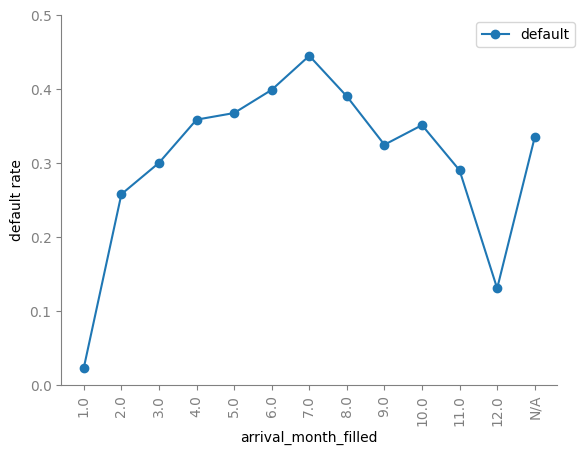

In [14]:
data['sample'] = 'default'
default_rate_in_time_per_sample(data, col_target,'arrival_month_filled', 'sample')

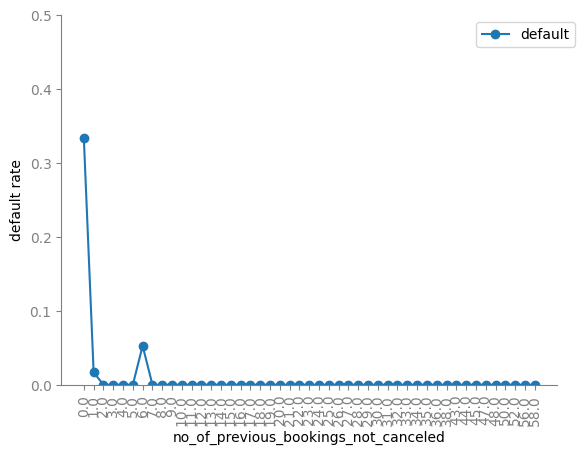

In [15]:
default_rate_in_time_per_sample(data, col_target,'no_of_previous_bookings_not_canceled', 'sample')

In [16]:
data['sample'] = 'default'

# define 'hoot' and 'oot' sample
#data.loc[data[col_month] <= 201701, 'sample'] = 'hoot'
#data.loc[data[col_month] >= 201911, 'sample'] = 'oot'

# define intime mask
#intime_mask = (data[col_month] > 201701) & (data[col_month] < 201911)
# use train_test_split to split the intime into train and rest (don't forget seed); use stratification
data_train, data_rest = train_test_split(data, test_size=0.4, random_state = 19, stratify = (data[[col_month, col_target]]))
data.loc[data_train.index, 'sample'] = 'train'
# use train_test_split to split the rest into valid and test (don't forget seed); use stratification
data_valid, data_test = train_test_split(data_rest, test_size=0.5, random_state = 19, stratify = (data_rest[[col_month, col_target]]))
data.loc[data_valid.index, 'sample'] = 'valid'
data.loc[data_test.index, 'sample'] = 'test'

## Define Sample Masks

In [17]:
# define sample masks
train_mask = (data['sample'] == 'train')
valid_mask = (data['sample'] == 'valid') 
test_mask = (data['sample'] == 'test') 
oot_mask = (data['sample'] == 'oot')  
hoot_mask = (data['sample'] == 'hoot')

# Data preprocessing

## Encode Categorical Predictors- XGBOOST NEUMI KATEGORIE - MUSIME PREVEST NA SPOJITE
- Category encoding is defined by:
$$ CategoryEncoding = \frac{f_{categ}\cdot DR_{category} + \alpha \cdot DR}{f_{categ} + \alpha} $$
where $f_{categ}$ is frequency of category to be encoded, $DR_{category}$ default rate in this category and $DR$ is total default rate.

In [18]:
# target_encoder = TargetEncoder(cols=cols_pred)

# # Fit the encoder on the training data
# target_encoder.fit(data[train_mask][cols_pred], data[train_mask][col_target])

# # Transform the features, replacing the categorical values with the mean target values
# data[train_mask][cols_pred] = target_encoder.transform(data[train_mask][cols_pred])
# data[test_mask][cols_pred] = target_encoder.transform(data[test_mask][cols_pred])

In [19]:
def mean_target_encoding(dt, predictor, target, alpha = 0.01):
    total_cnt = len(dt)
    total_dr = np.mean(dt[target])
    dt_grp = dt.groupby(predictor).agg(
        categ_dr = (target, 'mean'),
        categ_cnt = (target, len)
    )
    
    dt_grp['categ_freq'] = dt_grp['categ_cnt'] / total_cnt
    dt_grp['categ_encoding'] = (dt_grp['categ_freq'] * dt_grp['categ_dr'] + alpha * total_dr) / (dt_grp['categ_freq'] + alpha)
    
    return dt_grp[['categ_encoding']].to_dict()['categ_encoding']

In [20]:
total_dr = np.mean(data[train_mask][col_target])

# encode categorical predictors
for pred in tqdm(cols_pred_cat):
    if len(data[pred].unique()) < 0:
        dummies = pd.get_dummies(
            data[pred], 
            prefix = pred,
            prefix_sep = '_',
            dummy_na = True if data[pred].isnull().sum() > 0 else False,
            drop_first = False
        )
        
        for d in dummies.columns:
            if d in data.columns:
                del data[d]
                
        data = data.join(dummies)
        
        for col in dummies.columns:
            if col not in cols_pred:
                cols_pred.append(col)
        
        if pred in cols_pred:
            cols_pred.remove(pred)
    else:
        new_vals = mean_target_encoding(
            dt=data[train_mask], 
            predictor=pred, 
            target=col_target
        )

        additional_values = set(data[data[pred].notnull()][pred].unique()) - set(new_vals.keys())
        for p in additional_values:
            new_vals[p] = total_dr

        data['MTE_' + pred] = data[pred].map(new_vals)
        
        if 'MTE_' + pred not in cols_pred:
            cols_pred.append('MTE_' + pred)
        
        if pred in cols_pred:
            cols_pred.remove(pred)

  0%|          | 0/10 [00:00<?, ?it/s]

In [21]:
cols_pred

['required_car_parking_space',
 'lead_time',
 'avg_price_per_room',
 'repeated_guest',
 'arrival_year',
 'MTE_no_of_adults',
 'MTE_no_of_children',
 'MTE_no_of_weekend_nights',
 'MTE_no_of_week_nights',
 'MTE_type_of_meal_plan',
 'MTE_room_type_reserved',
 'MTE_no_of_previous_bookings_not_canceled',
 'MTE_no_of_special_requests',
 'MTE_market_segment_type',
 'MTE_arrival_month_filled']

# XGBoost model
- XGBoost model is provided in package `xgboost`
- https://xgboost.readthedocs.io/en/stable/

## First XGBoost model
- **early stopping:** Model is trained on training sample and we control model performance on evaluation sample (can be valid or test). If the model does not improve after *n* iterations, we stop the training.
- Data must be passed to training as *xgb.DMatrix* data type.
- Parameter *dtrain* defines data set to be used for training. Parameter evals is used for passing evaluation data sets - eval_metric will be evaluated on those sets in each iteration. Last data set from evals is used for early stopping.

In [23]:
# set best parameters to be used in XGBoost
params = {'colsample_bytree': 0.8, 'eta': 0.13, 'gamma': 0.05, 'lambda': 0.95, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.9,
       
    # 'max_depth': 5, # ?
    # 'eta': 0.1,
    # 'subsample': 0.8,
    # 'colsample_bytree': 0.6,

    # 'booster': 'gbtree',
    # 'tree_method': 'exact',

    # 'lambda': 0.9,
    # 'gamma': 0.05,
    
    'seed': 12,
    'objective': 'binary:logistic', # default je 'reg:squarederror', binary:logistic se pouziva na pravdepodobnosti (logisticka regrese)
    'eval_metric': 'auc'
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]),
    num_boost_round = 1000,
    evals = (
        (xgb.DMatrix(data[train_mask][cols_pred], data[train_mask][col_target]), 'train'),
        (xgb.DMatrix(data[test_mask][cols_pred], data[test_mask][col_target]), 'test'),
        (xgb.DMatrix(data[valid_mask][cols_pred], data[valid_mask][col_target]), 'valid'),        
    ),
    evals_result = evals_result,
    early_stopping_rounds = 10
)

[0]	train-auc:0.77291	test-auc:0.76658	valid-auc:0.74584
[1]	train-auc:0.78810	test-auc:0.77633	valid-auc:0.75573
[2]	train-auc:0.79532	test-auc:0.78424	valid-auc:0.76608
[3]	train-auc:0.79974	test-auc:0.78734	valid-auc:0.76597
[4]	train-auc:0.80083	test-auc:0.78845	valid-auc:0.76721
[5]	train-auc:0.80398	test-auc:0.79089	valid-auc:0.77255
[6]	train-auc:0.80640	test-auc:0.79362	valid-auc:0.77537
[7]	train-auc:0.80754	test-auc:0.79403	valid-auc:0.77555
[8]	train-auc:0.80978	test-auc:0.79567	valid-auc:0.77767
[9]	train-auc:0.81095	test-auc:0.79693	valid-auc:0.77900
[10]	train-auc:0.81375	test-auc:0.79797	valid-auc:0.78035
[11]	train-auc:0.81466	test-auc:0.79827	valid-auc:0.78141
[12]	train-auc:0.81611	test-auc:0.79856	valid-auc:0.78223
[13]	train-auc:0.81851	test-auc:0.80031	valid-auc:0.78336
[14]	train-auc:0.82068	test-auc:0.80108	valid-auc:0.78407
[15]	train-auc:0.82200	test-auc:0.80149	valid-auc:0.78511
[16]	train-auc:0.82331	test-auc:0.80172	valid-auc:0.78545
[17]	train-auc:0.82467	t

In [57]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define the parameter grid
param_grid = {
    'max_depth': [ 5,6,7],
    'min_child_weight': [1, 2],
    'gamma': [0.05],
    'subsample': [0.8,0.9],
    'colsample_bytree': [0.6, 0.7,  0.8],
    'lambda': [1.05, 1, 0.95], 
    'eta':[0.13, 0.15, 0.17] ,# L2 regularization term on weights (lambda)
    # You can add more hyperparameters here
}

xgb_model = xgb.XGBClassifier()

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='roc_auc', n_jobs=-1, cv=3, verbose=2)

# Prepare the data
dtrain = xgb.DMatrix(data[train_mask][cols_pred], label=data[train_mask][col_target])
dtest = xgb.DMatrix(data[test_mask][cols_pred], label=data[test_mask][col_target])
dvalid = xgb.DMatrix(data[valid_mask][cols_pred], label=data[valid_mask][col_target])

# Fit the grid search to the data
grid_search.fit(data[train_mask][cols_pred], data[train_mask][col_target])

# Get the best parameters and print them
best_parameters = grid_search.best_params_
print(f"Best parameters found: {best_parameters}")

best_parameters['eval_metric'] = 'auc'

# Train the model with the best parameters
# booster = xgb.train(
#     params=best_parameters,
#     dtrain=dtrain,
#     num_boost_round=1000,
#     evals=[(dtrain, 'train'), (dtest, 'test'), (dvalid, 'valid')],
#     evals_result=evals_result,
#     early_stopping_rounds=50
# )

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best parameters found: {'colsample_bytree': 0.8, 'eta': 0.13, 'gamma': 0.05, 'lambda': 0.95, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.9}


In [24]:
# A jak dobře predikuje na testu?

data['predicted_pd'] = booster.predict(xgb.DMatrix(data[cols_pred]), iteration_range=(0,booster.best_iteration)) # Tady bylo booster.best_iteration misto 265

data['Prediction'] = (data['predicted_pd']>=0.5).astype(int) 
data['Accuracy'] = 1-abs(data[col_target] - data['Prediction'])
print(data.groupby(col_month)['Accuracy'].mean())
print(data[test_mask]['Accuracy'].mean())


arrival_month_filled
1.0     0.978136
2.0     0.801480
3.0     0.757801
4.0     0.737374
5.0     0.758956
6.0     0.786762
7.0     0.785351
8.0     0.759135
9.0     0.797497
10.0    0.793410
11.0    0.791959
12.0    0.888631
N/A     0.771205
Name: Accuracy, dtype: float64
0.7614181761882645


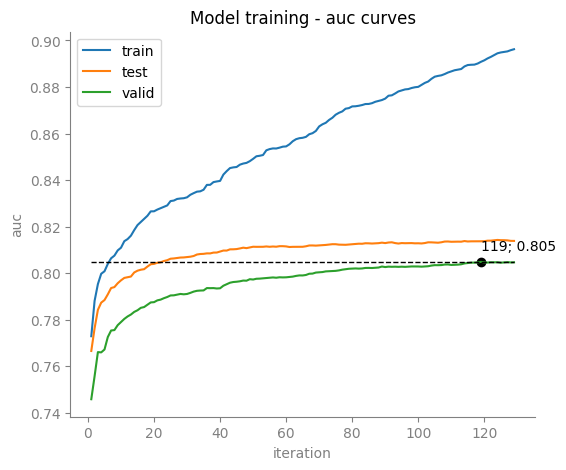

In [25]:
metric = 'auc'

fig = plt.figure(figsize=(6,5))
ax = plt.subplot(1,1,1)
total_iteration_count = len(evals_result[list(evals_result.keys())[0]][metric])
for sample, vals in evals_result.items():
    ax.plot(
        range(1, total_iteration_count + 1), 
        vals[metric],
        label=sample
    )

best_score = booster.best_score
best_iteration = booster.best_iteration+1

ax.plot([1, total_iteration_count], [best_score, best_score], color='black', ls='--', lw=1)
ax.scatter([best_iteration], [best_score], color = 'black')
ax.annotate(
    '{:d}; {:0.3f}'.format(best_iteration, best_score), 
    xy = (best_iteration, best_score), 
    xytext = (best_iteration,best_score+0.005),
)
ax.set_xlabel('iteration', color='gray')
ax.set_ylabel(metric, color='gray')
ax.legend(loc='best')
ax.set_title(f'Model training - {metric} curves')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

# plt.savefig('test.svg', format='svg')
# plt.close()

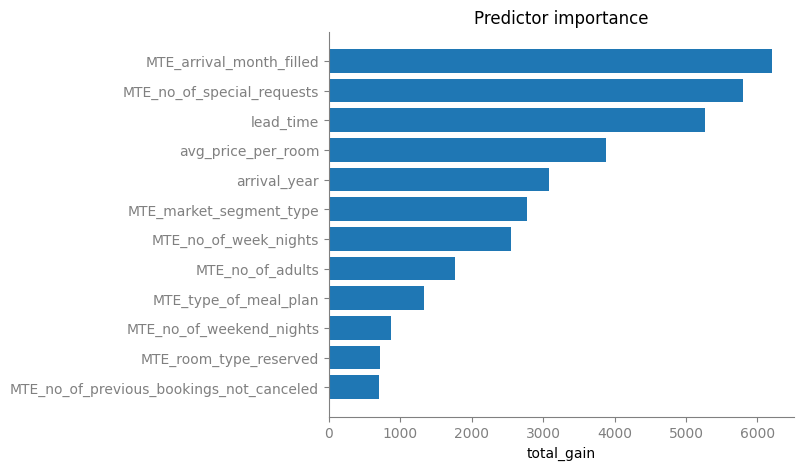

In [26]:
importance_type = 'total_gain' # TOTO NENÍ DOBRÉ POUŽÍVAT, PROTOŽE TO DŮLEŽITÝM PREDIKTORŮM MŮŽE DÁT NÍZKÉ HODNOTY. CELKOVĚ TO PREFERUJE PRVNÍ STROM.

predictor_strength = sorted([(k, v) for k,v in booster.get_score(importance_type = importance_type).items()], key = lambda x: x[1], reverse = True)
predictor_strength = pd.DataFrame(predictor_strength, columns = ['predictor', 'strength'])

fig = plt.figure(figsize=(6,5))

n_strongest = 12
plt.barh(range(n_strongest, 0, -1), predictor_strength['strength'].iloc[0:12])
plt.yticks(range(n_strongest, 0, -1), predictor_strength['predictor'].iloc[0:12])
plt.xlabel(importance_type)
plt.title('Predictor importance')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='y', colors='gray')
ax.tick_params(axis='x', colors='gray')

plt.show()

<span style="color:red">**TO DO:** change the hyperparameters and observe performance and training</span>

https://xgboost.readthedocs.io/en/stable/parameter.html PARAMETRY INFO

## Final model
Before fitting final model, selection of optimal predictors might be considered. A model with similar performance can be fitted using *n* strongest predictors or using all available predictors. Sometime implementation of the predictors into the production might take some time and therefore you prefer to have "reasonable" number of predictors in your model. On the contrary, having larger number of predictors might bring better robustness - if one of the predictors would broke, the impact for the model would be lower.

For selection of optimal predictors, similar approach as forward (or backward) process can be used.

In [27]:
# Final model
params = {
    'colsample_bytree': 0.8, 'eta': 0.13, 'gamma': 0.05, 'lambda': 0.95, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.9,
        
    # 'max_depth': 5, # ?
    # 'eta': 0.1,
    # 'subsample': 0.8,
    # 'colsample_bytree': 0.6,

    # 'booster': 'gbtree',
    # 'tree_method': 'exact',

    # 'lambda': 0.9,
    # 'gamma': 0.05,
    
    'seed': 12,
    'objective': 'binary:logistic',
    'eval_metric': 'auc'
}

evals_result = {}
booster = xgb.train(
    params = params,
    dtrain = xgb.DMatrix(data[cols_pred], data[col_target]),
    evals = (
        (xgb.DMatrix(data[cols_pred], data[col_target]), 'train'),
    ),
    num_boost_round = best_iteration+1,
    evals_result = evals_result
)

[0]	train-auc:0.77129
[1]	train-auc:0.78748
[2]	train-auc:0.79022
[3]	train-auc:0.79465
[4]	train-auc:0.79664
[5]	train-auc:0.79898
[6]	train-auc:0.80113
[7]	train-auc:0.80208
[8]	train-auc:0.80426
[9]	train-auc:0.80536
[10]	train-auc:0.80730
[11]	train-auc:0.80807
[12]	train-auc:0.80935
[13]	train-auc:0.81137
[14]	train-auc:0.81242
[15]	train-auc:0.81457
[16]	train-auc:0.81565
[17]	train-auc:0.81693
[18]	train-auc:0.81846
[19]	train-auc:0.81887
[20]	train-auc:0.82024
[21]	train-auc:0.82092
[22]	train-auc:0.82178
[23]	train-auc:0.82221
[24]	train-auc:0.82341
[25]	train-auc:0.82379
[26]	train-auc:0.82523
[27]	train-auc:0.82539
[28]	train-auc:0.82555
[29]	train-auc:0.82580
[30]	train-auc:0.82670
[31]	train-auc:0.82715
[32]	train-auc:0.82805
[33]	train-auc:0.82859
[34]	train-auc:0.82905
[35]	train-auc:0.83034
[36]	train-auc:0.83092
[37]	train-auc:0.83130
[38]	train-auc:0.83155
[39]	train-auc:0.83191
[40]	train-auc:0.83211
[41]	train-auc:0.83239
[42]	train-auc:0.83340
[43]	train-auc:0.8345

In [28]:
gini_train = 2 * roc_auc_score(data[col_target], booster.predict(xgb.DMatrix(data[cols_pred]))) - 1
print(gini_train)

0.7416057761874808


# Predikce

In [29]:
data['predicted_pd'] = booster.predict(xgb.DMatrix(data[cols_pred]), iteration_range=(0,best_iteration)) # Tady bylo booster.best_iteration misto 265
data['predicted_score'] = np.log(data['predicted_pd'] / (1 - data['predicted_pd']))

data['Prediction'] = (data['predicted_pd']>=0.5).astype(int) 
data['Accuracy'] = 1-abs(data[col_target] - data['Prediction'])
print(data.groupby(col_month)['Accuracy'].mean())
print(data['Accuracy'].mean())

arrival_month_filled
1.0     0.979287
2.0     0.800808
3.0     0.779099
4.0     0.741162
5.0     0.762937
6.0     0.792129
7.0     0.797493
8.0     0.764616
9.0     0.800250
10.0    0.797962
11.0    0.798595
12.0    0.897138
N/A     0.774554
Name: Accuracy, dtype: float64
0.7988543118129742


In [30]:
data_test_path = Path("C:/Users/erikm/Documents/data-science-2/Practicals/Data/2024_DS2_HW1_data_test.csv")
data_test = pd.read_csv(data_test_path, sep = ',', decimal = '.', index_col = 'Booking_ID')

data_test['arrival_month_filled'] = data_test['arrival_month'].fillna("N/A")

total_dr = np.mean(data[col_target])

# encode categorical predictors
for pred in tqdm(cols_pred_cat):
    new_vals = mean_target_encoding(
        dt=data[train_mask], 
        predictor=pred, 
        target=col_target
    )

    additional_values = set(data[data[pred].notnull()][pred].unique()) - set(new_vals.keys())
    for p in additional_values:
        new_vals[p] = total_dr

    data_test['MTE_' + pred] = data_test[pred].map(new_vals)
    
    if 'MTE_' + pred not in cols_pred:
        cols_pred.append('MTE_' + pred)
    
    if pred in cols_pred:
        cols_pred.remove(pred)


  0%|          | 0/10 [00:00<?, ?it/s]

In [95]:
data_test[cols_pred]

,required_car_parking_space,lead_time,avg_price_per_room,repeated_guest,arrival_year,MTE_no_of_adults,MTE_no_of_children,MTE_no_of_weekend_nights,MTE_no_of_week_nights,MTE_type_of_meal_plan,MTE_room_type_reserved,MTE_no_of_previous_bookings_not_canceled,MTE_no_of_special_requests,MTE_market_segment_type,MTE_arrival_month_filled
Booking_ID,,,,,,,,,,,,,,,
INN04969,NaN,NaN,NaN,NaN,2017.0,0.349409,NaN,0.350217,0.305976,0.306809,NaN,NaN,0.130496,NaN,0.384112
INN34541,0.0,NaN,NaN,NaN,2018.0,0.349409,0.331811,NaN,0.352434,0.306809,NaN,0.331685,NaN,0.301397,0.269974
INN36109,0.0,NaN,NaN,NaN,2018.0,0.349409,NaN,NaN,0.352434,0.306809,NaN,NaN,NaN,NaN,0.151957
INN01554,0.0,NaN,NaN,NaN,2018.0,0.349409,NaN,0.303986,0.327423,NaN,NaN,0.331685,0.428496,0.363067,0.391352
INN24975,0.0,NaN,NaN,NaN,2018.0,0.349409,NaN,NaN,NaN,NaN,NaN,NaN,0.151140,NaN,0.324664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INN29523,0.0,39.0,87.00,NaN,2017.0,0.242926,NaN,NaN,0.352434,0.444658,0.323632,NaN,NaN,0.301397,0.384112
INN25061,0.0,NaN,NaN,0.0,2018.0,0.349409,NaN,0.350217,NaN,0.323319,NaN,NaN,NaN,0.363067,0.391352
INN08475,NaN,308.0,78.30,NaN,2018.0,0.349409,NaN,NaN,NaN,NaN,NaN,0.331685,NaN,0.363067,0.294164


In [96]:
data_test['booking_status'] = booster.predict(xgb.DMatrix(data_test[cols_pred]), iteration_range=(0,best_iteration))
# data_test['prediction'] = (data_test['predicted_pd']>=0.5).astype(int) Toto nechteji

data_test.head()

subset_df = data_test[['booking_status']]

subset_df.reset_index(inplace=True)

subset_df.to_csv('output_data.csv', index=False)

## Score distribution - nevim k cemu je ted

In [82]:
def plot_score_calibration(dt, col_score, col_target, n_bins = 25):
    min_score = dt[col_score].min() - 0.1
    max_score = dt[col_score].max() + 0.1
    
    bins = [round(min_score + i * (max_score - min_score) / n_bins, 2) for i in range(n_bins+1)]
    dt = dt.assign(score_bin = pd.cut(dt[col_score], bins = bins, include_lowest = False))
    
    dt_grp = dt.groupby('score_bin', observed=False).agg(
        bad_cnt = (col_target, 'sum'),
        tot_cnt = (col_target, len),
        def_rt = (col_target, 'mean'),
        avg_score = (col_score, 'mean')
    )
    dt_grp['good_cnt'] = dt_grp['tot_cnt'] - dt_grp['bad_cnt']
    dt_grp['bad_cnt_norm'] = dt_grp['bad_cnt'] / dt_grp['tot_cnt']
    dt_grp['good_cnt_norm'] = dt_grp['good_cnt'] / dt_grp['tot_cnt']
    dt_grp['expected_pd'] = 1 / (1 + np.exp(-dt_grp['avg_score']))
    
    fig, axs = plt.subplots(1,2, figsize = (12,4))
    fig.suptitle(col_score)
    plt.subplots_adjust(wspace = 0.4)
    axs[0].bar(range(len(dt_grp)), dt_grp['bad_cnt'], color = 'salmon', label = 'bads')
    axs[0].bar(range(len(dt_grp)), dt_grp['good_cnt'], bottom = dt_grp['bad_cnt'], color = 'lightblue', label = 'goods')
    axs[0].set_ylabel('observations count')
    axs[0].set_xlabel('score')
    axs[0].set_xticks(range(len(dt_grp)))
    axs[0].set_xticklabels(dt_grp.index, rotation = 90)
    
    axs[0].spines['right'].set_color('gray')
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['left'].set_color('gray')
    axs[0].spines['bottom'].set_color('gray')
    axs[0].tick_params(axis='y', colors='gray')
    axs[0].tick_params(axis='x', colors='gray')
    
    ax0l = axs[0].twinx()
    ax0l.plot(range(len(dt_grp)), dt_grp['def_rt'], marker = 'o', color = 'red')
    ax0l.plot(range(len(dt_grp)), dt_grp['expected_pd'], color = 'black', ls = '--')
    ax0l.set_ylabel('default rate', color = 'red')
    
    ax0l.spines['right'].set_color('gray')
    ax0l.spines['top'].set_visible(False)
    ax0l.spines['left'].set_color('gray')
    ax0l.spines['bottom'].set_color('gray')
    ax0l.tick_params(axis='y', colors='gray')
    ax0l.tick_params(axis='x', colors='gray')
    
    axs[1].bar(range(len(dt_grp)), dt_grp['bad_cnt_norm'], color = 'salmon', label = 'bads')
    axs[1].bar(range(len(dt_grp)), dt_grp['good_cnt_norm'], bottom = dt_grp['bad_cnt_norm'], color = 'lightblue', label = 'goods')
    axs[1].set_ylabel('frequency')
    axs[1].set_xlabel('score')
    axs[1].set_xticks(range(len(dt_grp)))
    axs[1].set_xticklabels(dt_grp.index, rotation = 90)
    
    axs[1].spines['right'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['left'].set_color('gray')
    axs[1].spines['bottom'].set_color('gray')
    axs[1].tick_params(axis='y', colors='gray')
    axs[1].tick_params(axis='x', colors='gray')

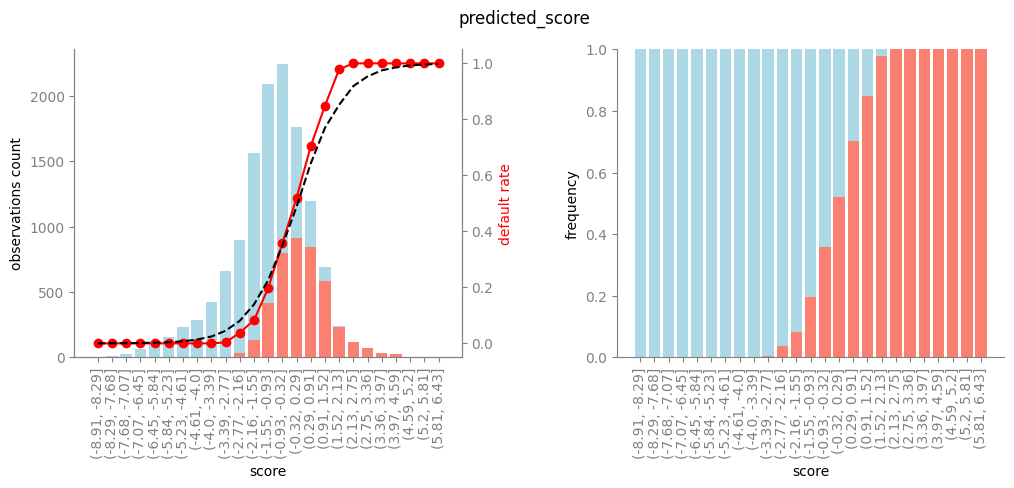

In [83]:
plot_score_calibration(data[valid_mask | test_mask], 'predicted_score', col_target)

## Marginal contribution - ODENDÁ regresor a udělá model bez něj a kouká jak moc se zhoršil. Může se ale např. stát že tam jsou 2 podobné velmi důležité proměnné ale odstranění jen jedné z nich doplní ta druhá.

In [74]:
 def fit_model(predictors):
    # params={
    #     'eta': 0.2,
    #     'max_depth': 3,

    #     'eval_metric': 'auc',
    #     'objective': 'binary:logistic' ,
    #     'booster': 'gbtree',
    #     'tree_method': 'hist',

    #     'base_score': 0.08,

    #     'seed': 12
    # }

    evals_result = {}

    booster_mc = xgb.train(
        params = params,
        dtrain = xgb.DMatrix(data[train_mask][predictors], data[train_mask][col_target]),
        num_boost_round = 1000,
        evals = (
            (xgb.DMatrix(data[train_mask][predictors], data[train_mask][col_target]), 'train'),
            (xgb.DMatrix(data[test_mask][predictors], data[test_mask][col_target]), 'test'),
            (xgb.DMatrix(data[valid_mask][predictors], data[valid_mask][col_target]), 'valid')
        ),
        evals_result = evals_result,
        early_stopping_rounds = 20
    )
    
    
    prediction = booster_mc.predict(xgb.DMatrix(data[test_mask][predictors]))
    return roc_auc_score(data[test_mask][col_target], prediction)

prediction = booster.predict(xgb.DMatrix(data[test_mask][cols_pred]), iteration_range=(0,best_iteration))
auc_base = roc_auc_score(data[test_mask][col_target], prediction)

marginal_contribution = []
for pred in tqdm(cols_pred):
    auc = fit_model(predictors=[p for p in cols_pred if p != pred])
    marginal_contribution.append((pred, auc_base - auc))

  0%|          | 0/15 [00:00<?, ?it/s]

[0]	train-auc:0.67675	test-auc:0.66218	valid-auc:0.66103
[1]	train-auc:0.71705	test-auc:0.70154	valid-auc:0.69630
[2]	train-auc:0.79246	test-auc:0.77234	valid-auc:0.75582
[3]	train-auc:0.79981	test-auc:0.78229	valid-auc:0.76335
[4]	train-auc:0.80172	test-auc:0.78457	valid-auc:0.76616
[5]	train-auc:0.80790	test-auc:0.79102	valid-auc:0.77283
[6]	train-auc:0.80980	test-auc:0.79186	valid-auc:0.77416
[7]	train-auc:0.81157	test-auc:0.79333	valid-auc:0.77630
[8]	train-auc:0.81326	test-auc:0.79440	valid-auc:0.77823
[9]	train-auc:0.81539	test-auc:0.79479	valid-auc:0.77956
[10]	train-auc:0.81592	test-auc:0.79528	valid-auc:0.77834
[11]	train-auc:0.81649	test-auc:0.79510	valid-auc:0.77821
[12]	train-auc:0.81695	test-auc:0.79458	valid-auc:0.77745
[13]	train-auc:0.81904	test-auc:0.79664	valid-auc:0.77905
[14]	train-auc:0.82058	test-auc:0.79765	valid-auc:0.78021
[15]	train-auc:0.82145	test-auc:0.79864	valid-auc:0.78128
[16]	train-auc:0.82168	test-auc:0.79917	valid-auc:0.78146
[17]	train-auc:0.82212	t

In [75]:
marginal_contribution = sorted(marginal_contribution, key=lambda x: x[1], reverse=False)

In [76]:
marginal_contribution

[('MTE_no_of_weekend_nights', 0.05620070501408847),
 ('repeated_guest', 0.05849862695602548),
 ('MTE_room_type_reserved', 0.058557137972907736),
 ('MTE_no_of_children', 0.05932684166700508),
 ('MTE_no_of_previous_bookings_not_canceled', 0.05957786047917024),
 ('MTE_type_of_meal_plan', 0.06058029829265732),
 ('required_car_parking_space', 0.06188151344421622),
 ('MTE_no_of_adults', 0.06507456661457445),
 ('MTE_no_of_week_nights', 0.06585038339998783),
 ('avg_price_per_room', 0.06594202518855596),
 ('MTE_market_segment_type', 0.07070761651879531),
 ('lead_time', 0.07181736091734792),
 ('arrival_year', 0.08326696262761624),
 ('MTE_arrival_month_filled', 0.0903837471241179),
 ('MTE_no_of_special_requests', 0.13428294748810898)]

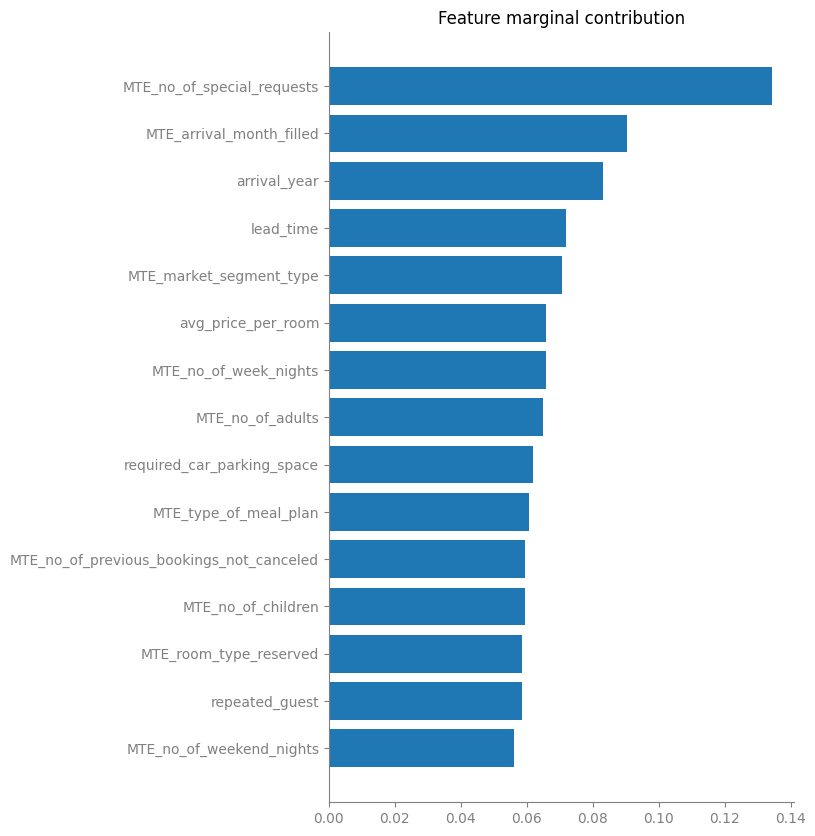

In [77]:
# feature_perm_importance = sorted(zip(cols_pred, pi['importances_mean']), key=lambda x: x[1], reverse=False)

plt.figure(figsize=(6,10))
ax = plt.subplot(1,1,1)
ax.barh(range(len(marginal_contribution)), [imp for p, imp in marginal_contribution])
ax.set_yticks(range(len(marginal_contribution)))
ax.set_yticklabels([p for p, imp in marginal_contribution])

ax.set_title('Feature marginal contribution')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.tick_params(axis='x', colors='gray')
ax.tick_params(axis='y', colors='gray')

plt.show()

## SHAP - NEJPROPRACOVANĚJŠÍ SYSTÉM HODNOCENÍ (?)
- SHAP = SHapley Additive exPlanations
- Original paper presenting SHAP values can be downloaded here: <a href=https://arxiv.org/abs/1705.07874 target="_blank">SHAP values</a>
- SHAP values are defined by following equation:
$$ \phi_i = \sum_{S\subseteq F\setminus\lbrace i \rbrace} \frac{|S|!(|F|-|S|-1)!}{|F|!} [f_{S\cup \lbrace i\rbrace}(x_{S\cup \lbrace i\rbrace})-f_S(x_S)] $$
where:

    - $F$ ... set of all model features
    - $S$ ... $S \subseteq F \setminus\lbrace i\rbrace$
    - $\phi_i$ ... SHAP value for predictor $x_i$
    - $f_S(x_S)$ ... output of model build on feature set $S$ given feature values $x_S$

In [78]:
import shap
shap.initjs()

In [79]:
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(data[cols_pred])

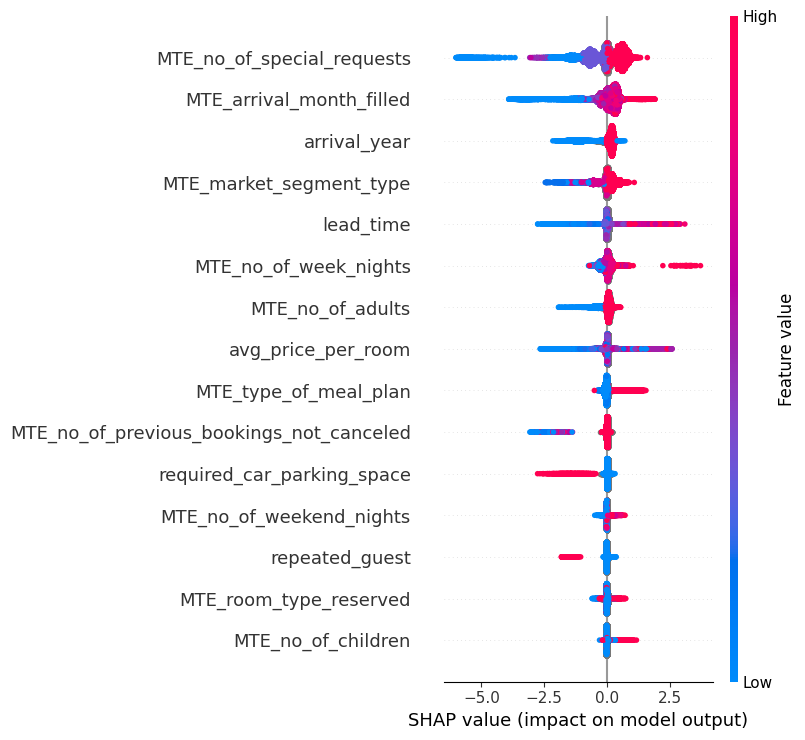

<function matplotlib.pyplot.show(close=None, block=None)>

In [80]:
plt.figure()
shap.summary_plot(shap_values, data[cols_pred], max_display=20, show=True)
plt.show # TADY NAPŘIKLAD NIZKE HODNOTY EXT SOURCE 2 ZVYSUJI VYRAZNE RIZIKO

In [81]:
shap.force_plot(explainer.expected_value, shap_values[0,:], data[cols_pred].iloc[0,:])

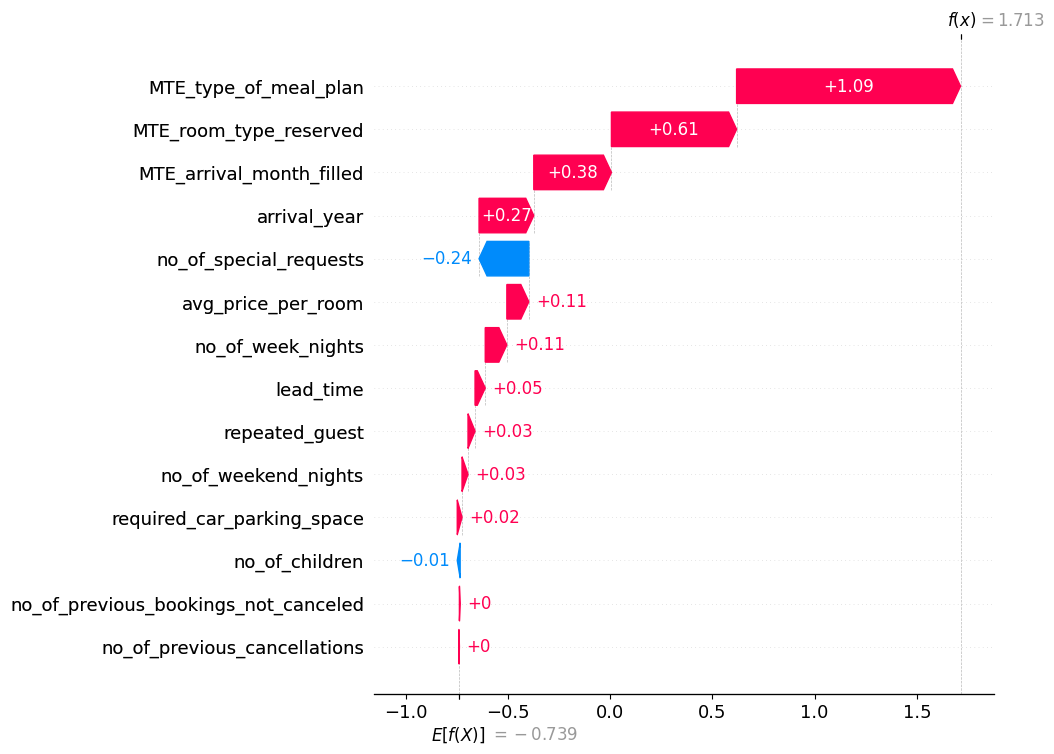

In [97]:
shap.plots._waterfall.waterfall_legacy(
    expected_value=explainer.expected_value, 
    shap_values=shap_values[0, :], 
    feature_names=cols_pred, 
    max_display=20
)

### SHAP interaction values

In [90]:
Xd = xgb.DMatrix(data[train_mask][cols_pred].iloc[:1000], data[train_mask][col_target].iloc[:1000])

explainer = shap.TreeExplainer(booster)
shap_interaction_values = explainer.shap_interaction_values(Xd)

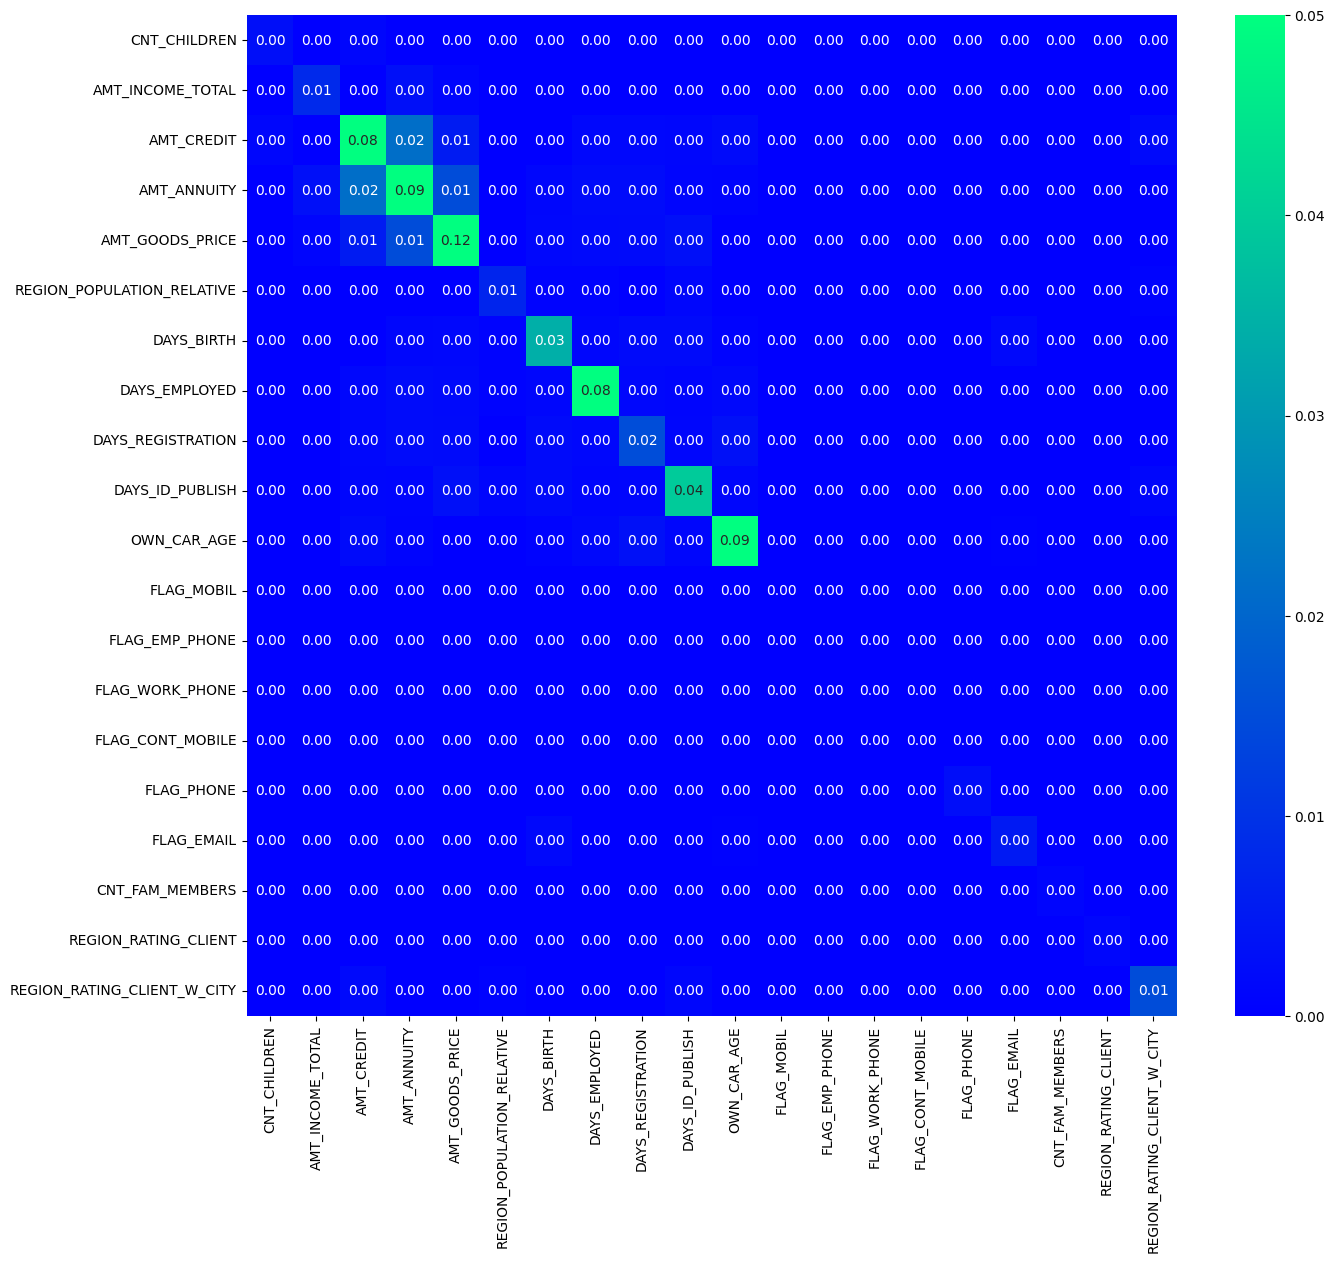

In [91]:
plt.figure(figsize=(15,13))

sns.heatmap(
    data=np.mean(abs(shap_interaction_values[:, 0:20, 0:20]), axis=0), 
    annot=True, 
    fmt='.2f', 
    xticklabels=cols_pred[0:20], 
    yticklabels=cols_pred[0:20],
    cmap='winter',
    vmax=0.05
)

plt.show()

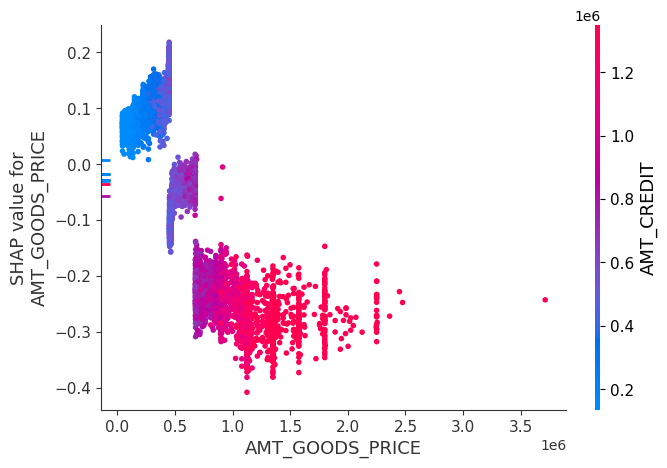

In [92]:
n_observations = 10000

dt_shap = data.iloc[0:n_observations]
dt_shap = dt_shap[cols_pred]
shap.dependence_plot('AMT_GOODS_PRICE', shap_values[:n_observations], dt_shap, interaction_index = 'AMT_CREDIT')

Better example of high interaction: https://h1ros.github.io/posts/explain-the-interaction-values-by-shap/

In [ ]:
# def marginal_dependence(data, predictor, bins, col_target):
#     dt = data.copy()
#     dt[predictor + 'bin'] = pd.qcut(dt[predictor], bins).copy()
#     dt.groupby(predictor + 'bin').agg(
#         def_rt=(col_target, np.mean),
#     ).plot(figsize=(9, 6))